<div class="alert alert-success">
<b>Reviewer's comment V2</b>

The project is accepted! Good luck on the next sprint! :)

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job overall, but there are some problems with the modeling section which need to be fixed before the project is accepted. Let me know if you have any further questions!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to **predict** the amount of taxi orders for **the next hour**. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

#### Import libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
state=89513

#### Data read and check

In [2]:
# look at the first rows of the data
pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv").head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
# read the data with dates parsing, make datetime column index
data = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", parse_dates=["datetime"], index_col="datetime", )
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# check whether the order of rows is chronological
data.index.is_monotonic

True

In [5]:
# resample the data by one hour
data = data.resample("1H").sum()

In [6]:
# remove index name
data.index.name = None

In [7]:
# convert the dataframe into series
series = data["num_orders"]

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and correctly resampled. Good idea to check that the order is correct when working with time series

</div>

## Analysis

#### First overview

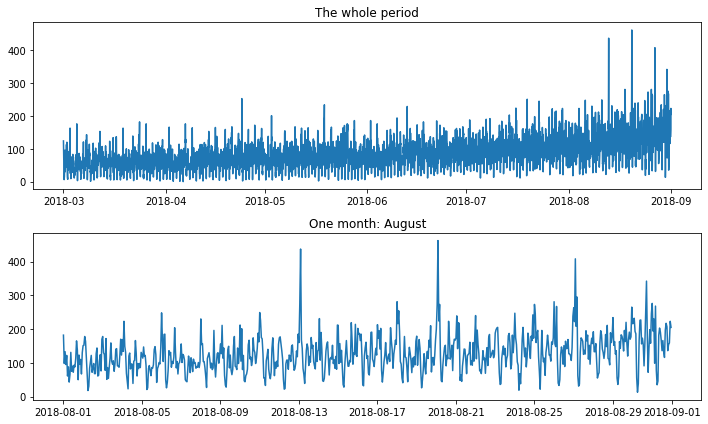

In [8]:
# plot the data for the whole period
plt.subplot(211)
plt.plot(series)
plt.title("The whole period")

# select only the last month
plt.subplot(212)
plt.plot(series["2018-08"])
plt.title("One month: August")

plt.tight_layout();

**NOTE**  
Because of variations and the high frequency of the time series intervals, it is difficult to say whether the data is stationary.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright!

</div>

### Check stationarity

#### Draw rolling statistics

In [9]:
# create a function for drawing the rolling window statistics
def get_rolling(data, rolling_window):
    
    # determine the rolling statistics
    rolling_mean = data.rolling(rolling_window).mean()
    rolling_std = data.rolling(rolling_window).std()
    
    # plot the rolling statistics
    plt.plot(data, color="lightgray", label="Original Data")
    plt.plot(rolling_mean, color="steelblue", label="Rolling Mean")
    plt.plot(rolling_std, color="gold", label="Rolling Std")
    
    plt.xticks(rotation=30)
    plt.legend(loc="best")
    plt.title("Rolling Statistics VS Original Data | window of {} hours".format(rolling_window));

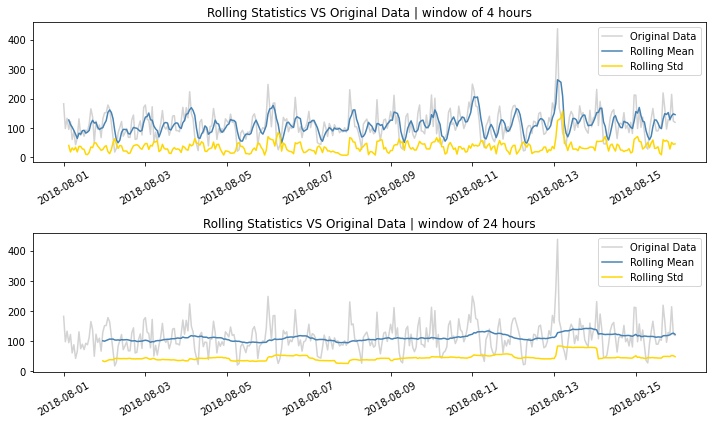

In [10]:
# select the time period
date_from, date_to = "2018-08-01","2018-08-15"

# plot satatistics for selected period with the window of 4 hours
plt.subplot(211)
get_rolling(series[date_from:date_to], 4)

# with the window of 24 hours
plt.subplot(212)
get_rolling(series[date_from:date_to], 24)

plt.tight_layout()

**NOTE**  
This series seems to be distributed around the average of the day, but it is still not clear whether its variations are stationary or random.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Very good!

</div>

#### Decompose series

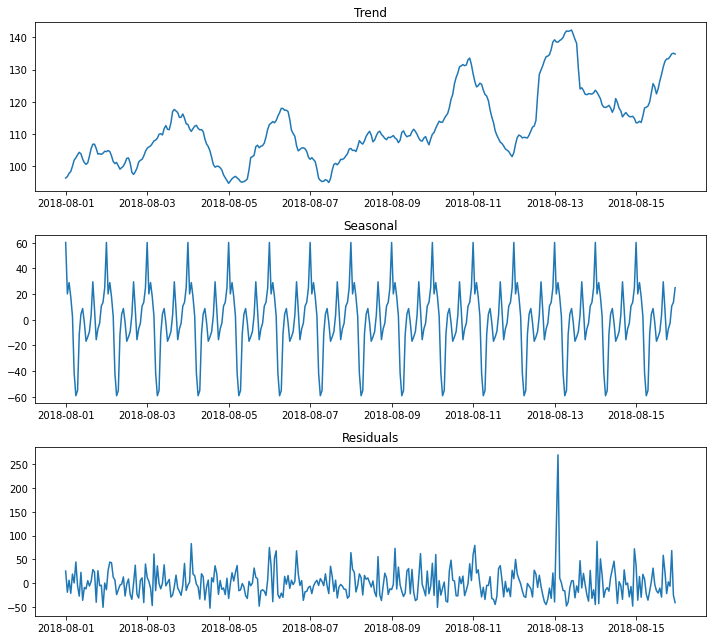

In [11]:
# select the time period
date_from, date_to = "2018-08-01","2018-08-15"

# decompose the series
decomposed = seasonal_decompose(series)

# store decomposed data into variables
trend = decomposed.trend
seasonal = decomposed.seasonal
residuals = decomposed.resid

# plot the decomposed time series
plt.figure(figsize=(10, 9))

plt.subplot(311)
plt.plot(trend[date_from:date_to])
plt.title("Trend")

plt.subplot(312)
plt.plot(seasonal[date_from:date_to])
plt.title("Seasonal")

plt.subplot(313)
plt.plot(residuals[date_from:date_to])
plt.title("Residuals")

plt.tight_layout();

**NOTE**  

After decomposing, we can see a clear seasonal component, but the trend looks complicated and there are a lot of residuals left. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent, you did a seaonal decomposition

</div>

#### Statistical test

Run Augmented Dickey-Fuller test to confirm that our series is stationary. *The null hypothesis is that given series has a union root and is non-stationary*. If p-value is greater than alpha, we cannot reject this hypothesis; if less — we reject the null hypothesis and consider the given series being stationary.

> [...] We can see that our [ADF] statistic value [...] is less than the value [...] at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. - [Machine Learning Mastery: How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)

In [12]:
result = adfuller(series.values)

adf_statistic = result[0]
p = result[1]
crit_values = result[4]
alpha = 0.05

print('p-value: %f' % result[1])

if (p >= alpha) & (crit_values['5%'] < adf_statistic):
    print("Fail to reject H0: Non-stationary")
else:
    print("Reject H0: Stationary")

p-value: 0.028940
Reject H0: Stationary


<div class="alert alert-success">
<b>Reviewer's comment</b>

Great!

</div>

### Autocorrelation

Use ACF and PACF to find determine which lags are most correlated with the current value.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


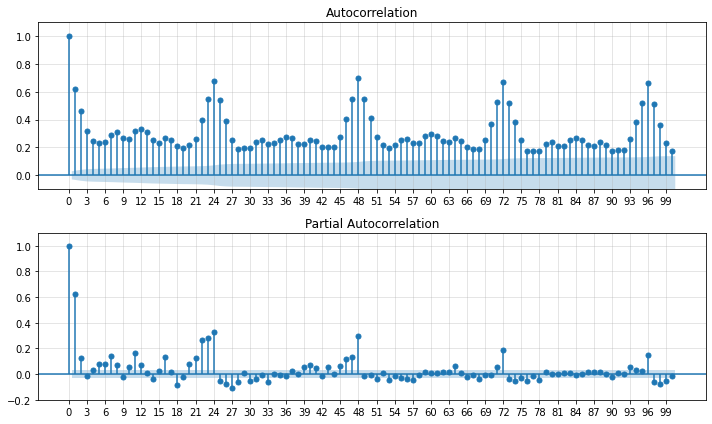

In [13]:
f, ax = plt.subplots(2,1)
# plot autocorrelation function
plot_acf(series, ax=ax[0], lags=100)
ax[0].set_ylim(-0.1, 1.1)
ax[0].set_xticks(np.arange(0,102, 3))
ax[0].grid(alpha=0.4)
# plt partial autocorrelation function
plot_pacf(series, ax=ax[1], lags=100)
ax[1].set_ylim(-0.2, 1.1)
ax[1].set_xticks(np.arange(0,102, 3))
ax[1].grid(alpha=0.4)

plt.tight_layout();

**NOTE**

The current number of taxi orders is mostly correlated with that value in previous hour, and then every 24 hours with gradual decay.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent work on EDA!

</div>

***

## Model Training

#### Feature engineering

In [14]:
# create a function for adding features to the data
def get_features(data, max_lag, rolling_window):
    data["month"] = data.index.month
    data["day"] = data.index.day
    data["dayofweek"] = data.index.dayofweek
    data["hour"] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data["lag_{}".format(lag)] = data["num_orders"].shift(lag)
    
    data["rolling_mean"] = data["num_orders"].shift().rolling(rolling_window).mean()

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Feature engineering looks good: there are calendar features, lag features and a shifted rolling mean. One obvious addition is an hour feature (which would allow to capture intra-day seaonality pattern)

</div>

<div class="alert alert-block alert-info">
<b>Student's comment: </b> 
    Yes! 🤦🏻
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

:)

</div>

In [15]:
# create new features with the lag of 24 hours and rolling mean of 4 hours
get_features(data, 24, 4)

In [16]:
# add more lags for every next 24 hours
for lag in [48, 72, 96, 120]:
    data["lag_{}".format(lag)] = data["num_orders"].shift(lag)

In [17]:
# look at the resulting dataset
data.sample(3)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,lag_48,lag_72,lag_96,lag_120
2018-05-22 18:00:00,44,5,22,1,18,64.0,124.0,60.0,62.0,66.0,...,65.0,93.0,59.0,90.0,62.0,77.50,57.0,46.0,60.0,41.0
2018-03-29 13:00:00,51,3,29,3,13,33.0,81.0,72.0,61.0,61.0,...,55.0,84.0,45.0,42.0,37.0,61.75,24.0,50.0,38.0,40.0
2018-06-16 05:00:00,76,6,16,5,5,100.0,115.0,173.0,106.0,104.0,...,74.0,69.0,27.0,26.0,79.0,123.50,36.0,34.0,55.0,68.0


#### Data preparation

In [18]:
# separate features from target
X = data.drop("num_orders", axis=1)
y = data["num_orders"]

# split the data into the training and the test set
X_, X_test, y_, y_test = train_test_split(X, y, shuffle=False, test_size=.1)

# drop the first rows which contain missing values
X_ = X_.dropna()
y_ = y_[y_.index.isin(X_.index)]

# add the validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, shuffle=False, test_size=.115)

# print the datasets sizes
print("Train size: {}".format(X_train.shape[0]),
      "\nValid size:  {}".format(X_valid.shape[0]), 
      "\nTest size:  {}".format(X_test.shape[0]))

Train size: 3410 
Valid size:  444 
Test size:  442


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test sets without shuffling

</div>

#### The baseline

In [19]:
# create a baseline using the value from the previous hour as a prediction
y_pred = y_valid.shift(fill_value=y_train.iloc[-1])

mean_squared_error(y_valid, y_pred, squared=False)

47.57999428179721

#### LinearRegression

In [20]:
# import and fit the model
lr = LinearRegression().fit(X_train, y_train)

# evaluate the model
mean_squared_error(y_valid, lr.predict(X_valid), squared=False)

30.197007785488985

#### RandomForest

In [21]:
# improt and fit the model
forest = RandomForestRegressor(random_state=state).fit(X_train, y_train)

# evaluate the model
mean_squared_error(y_valid, forest.predict(X_valid), squared=False)

32.05342219013594

In [22]:
# add hyperparamethers tuning
best_rmse = 99999
best_forest = None

for max_features in range(16, 34, 4):
    for max_depth in range(8, 20, 2):
        for n_estimators in range(10, 120, 20):
            forest = RandomForestRegressor(random_state=state,
                                           max_features=max_features,
                                           max_depth=max_depth,
                                           n_estimators=n_estimators,
                                           n_jobs=-1
                                          ).fit(X_train, y_train)

            # evaluate the model
            rmse = mean_squared_error(y_valid, forest.predict(X_valid), squared=False)

            print("RMSE: ", f"{rmse:.2f}",
                  " | ", "max_feaures: ", max_features,
                  " | ", "max_depth: ", max_depth, 
                  " | ", "n_estimators: ", n_estimators
                 )

            if rmse < best_rmse:
                best_rmse = rmse
                best_forest = forest
                
print("Best RMSE: ", f"{best_rmse:.2f}")
best_forest.get_params()

RMSE:  33.83  |  max_feaures:  16  |  max_depth:  8  |  n_estimators:  10
RMSE:  32.86  |  max_feaures:  16  |  max_depth:  8  |  n_estimators:  30
RMSE:  32.80  |  max_feaures:  16  |  max_depth:  8  |  n_estimators:  50
RMSE:  32.75  |  max_feaures:  16  |  max_depth:  8  |  n_estimators:  70
RMSE:  32.63  |  max_feaures:  16  |  max_depth:  8  |  n_estimators:  90
RMSE:  32.63  |  max_feaures:  16  |  max_depth:  8  |  n_estimators:  110
RMSE:  33.86  |  max_feaures:  16  |  max_depth:  10  |  n_estimators:  10
RMSE:  32.73  |  max_feaures:  16  |  max_depth:  10  |  n_estimators:  30
RMSE:  32.32  |  max_feaures:  16  |  max_depth:  10  |  n_estimators:  50
RMSE:  32.21  |  max_feaures:  16  |  max_depth:  10  |  n_estimators:  70
RMSE:  32.12  |  max_feaures:  16  |  max_depth:  10  |  n_estimators:  90
RMSE:  32.21  |  max_feaures:  16  |  max_depth:  10  |  n_estimators:  110
RMSE:  32.92  |  max_feaures:  16  |  max_depth:  12  |  n_estimators:  10
RMSE:  32.13  |  max_feaures:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 12,
 'max_features': 24,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 89513,
 'verbose': 0,
 'warm_start': False}

#### CatBoost

In [23]:
# improt and fit the base model
cat = CatBoostRegressor(random_seed=state, verbose=0).fit(X_train, y_train)

# evaluate the model
mean_squared_error(y_valid, forest.predict(X_valid), squared=False)

31.820440315695496

In [ ]:
# add hyperparamethers tuning
best_rmse = 99999
best_cat = None

for iterations in range(50,200,50):
    for learning_rate in np.arange(0.1,0.4,0.05):
        for depth in range(4, 12, 2):
            cat = CatBoostRegressor(random_seed=state,
                                    iterations=iterations,
                                    learning_rate=learning_rate,
                                    depth=depth,
                                    verbose=0
                                   ).fit(X_train, y_train)

            # evaluate the model
            rmse = mean_squared_error(y_valid, cat.predict(X_valid), squared=False)
            
            print("RMSE: ", f"{rmse:.2f}",
                  " | ", "iterations: ", iterations,
                  " | ", "depth: ", depth, 
                  " | ", "learning_rate: ", learning_rate
                 )

            if rmse < best_rmse:
                best_rmse = rmse
                best_cat = cat
                
print("Best RMSE: ", f"{best_rmse:.2f}")
best_cat.get_params()

RMSE:  32.57  |  iterations:  50  |  depth:  4  |  learning_rate:  0.1
RMSE:  32.67  |  iterations:  50  |  depth:  6  |  learning_rate:  0.1
RMSE:  32.46  |  iterations:  50  |  depth:  8  |  learning_rate:  0.1
RMSE:  33.33  |  iterations:  50  |  depth:  10  |  learning_rate:  0.1
RMSE:  32.19  |  iterations:  50  |  depth:  4  |  learning_rate:  0.15000000000000002
RMSE:  31.47  |  iterations:  50  |  depth:  6  |  learning_rate:  0.15000000000000002
RMSE:  32.28  |  iterations:  50  |  depth:  8  |  learning_rate:  0.15000000000000002
RMSE:  32.24  |  iterations:  50  |  depth:  10  |  learning_rate:  0.15000000000000002
RMSE:  31.45  |  iterations:  50  |  depth:  4  |  learning_rate:  0.20000000000000004
RMSE:  31.50  |  iterations:  50  |  depth:  6  |  learning_rate:  0.20000000000000004
RMSE:  31.86  |  iterations:  50  |  depth:  8  |  learning_rate:  0.20000000000000004
RMSE:  32.51  |  iterations:  50  |  depth:  10  |  learning_rate:  0.20000000000000004
RMSE:  31.36  |  

**NOTE**  

A simple LinearRegression model showed being the best.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

It's great that you tried a few different models, but there are some problems with modeling:
    
1. It is not possible to detect overfitting by evaluating the model on the train set. By definition, the model is overfitted when it shows good performance on the train set, but poor performance on the validation/test set. If you calculate only the train set score, you can't possibly know if a model is overfitted.
2. That brings us to the second point: train set score tells us nothing about how well the model generalizes to new data (which is what we want from our models), only how well it memorized the train set. So it doesn't make sense to compare different models and tune hyperparameters using train set scores, as it will always lead to simply selecting the most complicated model. What do we do instead? There are two options:
    
    - use a separate validation set 
    - use cross-validation (for time series regular k-fold cross-validation is not suitable due to mixing of train and validation data in all but one folds, but we can use a [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) instead: just pass an object of this class as the `cv` parameter of `cross_val_score`, `GridSearchCV`, etc.)

So, yeah, it's not clear to me how you selected the best model based on train scores :)
    
</div>

<div class="alert alert-block alert-info">
<b>Student's comment: </b> 
    Super! I felt that something is wrong 😅. Now it makes sense! I tried this TimeSeriesSplit thing, by the way, but hyperparameters tuning didn't make much of a difference for this dataset, so I decided to use the simplest solution.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Ok, sure! :)

</div>

***

## Testing

In [ ]:
# fit the model on the whole dataset
lr.fit(X_, y_)

# baseline for the test set
y_pred = y_test.shift(fill_value=y_.iloc[-1])
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
# predictions for the test set
y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The final model was evaluated on the test set

</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>

You're welcome! :)
    
I addressed this question in another comment above. One addition: if you use a validation set, then after you're done with hyperparameter tuning/model selection, it's important to refit your final model using the combined train+validation set before evaluating it on the test set to make sure that there is no gap between the data the model is trained on and the data it is evaluated on.

</div>

<div class="alert alert-block alert-info">
<b>Student's comment: </b> 
    I've tried the three common types of models, but I feel that I can do something else here. If you were me, which models would you try for this task? Except ARMA / ARIMA I guess... I've read about those, but not sure that I'm able to use them at the moment.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Well, ARIMA is basically linear regression with some feature engineering (in particular lag features and moving average, which we already included).
    
It would be interesting to try something like a [recurrent neural network](https://towardsdatascience.com/learn-how-recurrent-neural-networks-work-84e975feaaf7). Check out [this tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series) for example

</div>

## Conclusion

The best model for predicting the next hour amount of taxi orders is LinearRegression with an average error of 40 on the test set.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48